王起凡-24B918010-数据挖掘大报告

In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
import urllib.request

# 下载MAGIC gamma telescope数据集
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data"
data = pd.read_csv(url, header=None)

# 添加有意义的列名
feature_names = [
    'fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 
    'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist'
]
data.columns = feature_names + ['class']

# 查看数据集的前几行
print("MAGIC Gamma Telescope数据集预览:")
print(data.head())
print("\n数据集基本信息:")
print(f"样本数量: {len(data)}")
print(f"特征数量: {len(feature_names)}")
print(f"类别: {data['class'].unique()}")  # g为gamma信号(信号)，h为hadron信号(背景)
print(f"\n每个类别的样本数量:\n{data['class'].value_counts()}")

MAGIC Gamma Telescope数据集预览:
    fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist class  
0  40.0920   81.8828     g  
1   6.3609  205.2610     g  
2  76.9600  256.7880     g  
3  10.4490  116.7370     g  
4   4.6480  356.4620     g  

数据集基本信息:
样本数量: 19020
特征数量: 10
类别: ['g' 'h']

每个类别的样本数量:
class
g    12332
h     6688
Name: count, dtype: int64


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

# 获取特征和标签
X = data[feature_names]  # 选择特征列
y = (data['class'] == 'g').astype(int)  # 将'g'编码为1,'h'编码为0

# 修正后的类别平衡处理
gamma_indices = np.where(y == 1)[0]
hadron_indices = np.where(y == 0)[0]

# 确定较小的类别
min_class_size = min(len(gamma_indices), len(hadron_indices))

# 从两个类别中分别随机选择相同数量的样本
selected_gamma_indices = np.random.choice(gamma_indices, min_class_size, replace=False)
selected_hadron_indices = np.random.choice(hadron_indices, min_class_size, replace=False)
# 合并选择的样本索引
balanced_indices = np.concatenate([selected_gamma_indices, selected_hadron_indices])
X_balanced = X.iloc[balanced_indices]
y_balanced = y.iloc[balanced_indices]

# 将数据集分割成训练集和测试集，70% 用于训练，30% 用于测试
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, 
    y_balanced, 
    test_size=0.3,  # 30%用于测试
    random_state=42,  # 设置随机种子
    stratify=y_balanced  # 确保划分后类别比例保持一致
)

print("\n平衡后的数据集大小:")
print(f"训练集大小: {X_train.shape[0]}, 测试集大小: {X_test.shape[0]}")
print(f"\n训练集类别分布:\n{pd.Series(y_train).value_counts()}")
print(f"\n测试集类别分布:\n{pd.Series(y_test).value_counts()}")


平衡后的数据集大小:
训练集大小: 9363, 测试集大小: 4013

训练集类别分布:
class
1    4682
0    4681
Name: count, dtype: int64

测试集类别分布:
class
0    2007
1    2006
Name: count, dtype: int64


In [5]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_clf = DecisionTreeClassifier(max_depth=3)  # 限制深度以防止过拟合

# 创建AdaBoost分类器
clf = AdaBoostClassifier(
    base_estimator=base_clf,
    n_estimators=100,  # 弱分类器的数量
    learning_rate=1.0,  # 学习率
    random_state=42  # 随机种子
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AdaBoost模型信息:")
print(f"基学习器数量: {clf.n_estimators}")
print(f"学习率: {clf.learning_rate}")
print(f"基学习器类型: DecisionTreeClassifier(max_depth=3)")

d:\learnsoftware\python\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost模型信息:
基学习器数量: 100
学习率: 1.0
基学习器类型: DecisionTreeClassifier(max_depth=3)


准确率: 0.84

混淆矩阵:
[[1655  352]
 [ 273 1733]]


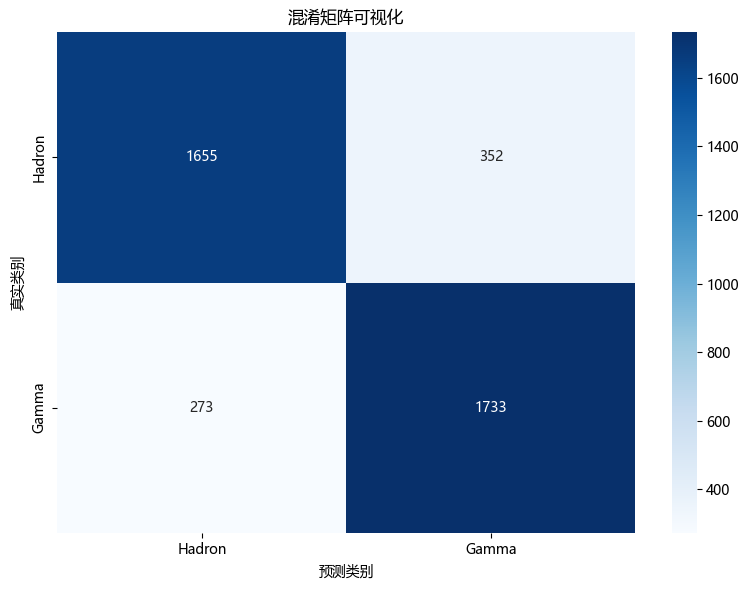

              precision    recall  f1-score   support

      Hadron       0.86      0.82      0.84      2007
       Gamma       0.83      0.86      0.85      2006

    accuracy                           0.84      4013
   macro avg       0.84      0.84      0.84      4013
weighted avg       0.84      0.84      0.84      4013



In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 设置中文字体 不然显示不出来
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

accuracy = accuracy_score(y_test, y_pred)
print(f"准确率: {accuracy:.2f}")
cm = confusion_matrix(y_test, y_pred)
print("\n混淆矩阵:")
print(cm)

# 可视化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('混淆矩阵可视化', fontsize=12)
plt.xlabel('预测类别', fontsize=10)
plt.ylabel('真实类别', fontsize=10)
labels = ['Hadron', 'Gamma']
plt.xticks([0.5, 1.5], labels)
plt.yticks([0.5, 1.5], labels)

plt.tick_params(labelsize=10)  
plt.tight_layout()  # 自动调整布局
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Hadron', 'Gamma']))

d:\learnsoftware\python\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


最佳超参数: {'base_estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 150}
最佳交叉验证分数: 0.850

测试集准确率: 0.8552205332668826

分类报告:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      2007
           1       0.83      0.89      0.86      2006

    accuracy                           0.86      4013
   macro avg       0.86      0.86      0.86      4013
weighted avg       0.86      0.86      0.86      4013



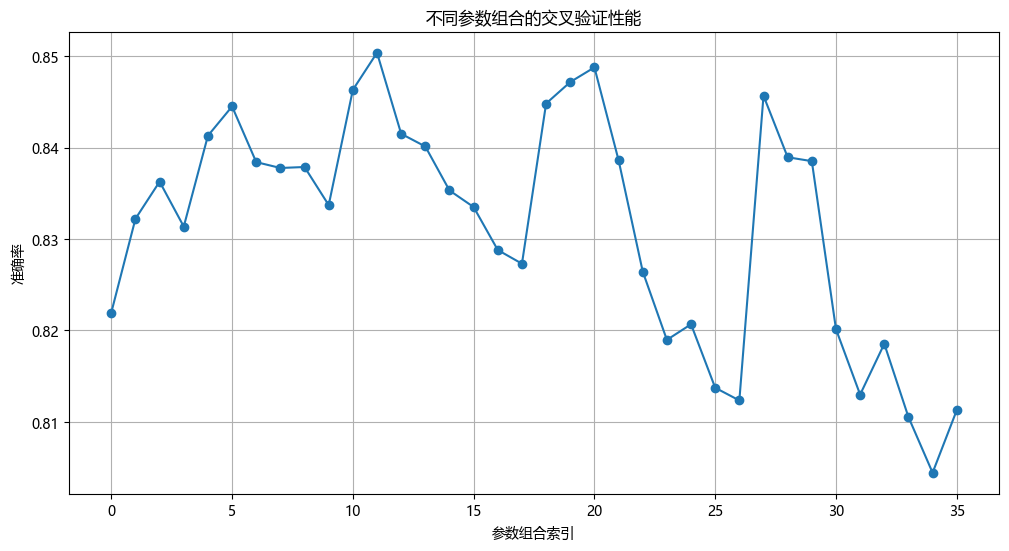

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# 创建参数字典
param_grid = {
    'base_estimator__max_depth': [2, 3, 4, 5],  # 基学习器的深度
    'n_estimators': [50, 100, 150],  # 弱分类器数量
    'learning_rate': [0.1, 0.5, 1.0]  # 学习率
}

# 创建基础决策树分类器
base_clf = DecisionTreeClassifier(random_state=42)

# 创建AdaBoost分类器
ada_clf = AdaBoostClassifier(
    base_estimator=base_clf,
    random_state=42
)

# 创建GridSearchCV
grid_search = GridSearchCV(
    ada_clf,
    param_grid,
    cv=5, 
    scoring='accuracy',  
    n_jobs=-1  
)

# 参数优化
grid_search.fit(X_train, y_train)
# 输出最佳参数和得分
print("最佳超参数:", grid_search.best_params_)
print(f"最佳交叉验证分数: {grid_search.best_score_:.3f}")

# 最佳参数
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 评估最终模型
from sklearn.metrics import accuracy_score, classification_report
print("\n测试集准确率:", accuracy_score(y_test, y_pred))
print("\n分类报告:")
print(classification_report(y_test, y_pred))

# 可视化
import pandas as pd
import matplotlib.pyplot as plt

# 将cv_results_转换为DataFrame
results = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(12, 6))
plt.plot(results['mean_test_score'], 'o-')
plt.title('不同参数组合的交叉验证性能', fontsize=12)
plt.xlabel('参数组合索引', fontsize=10)
plt.ylabel('准确率', fontsize=10)
plt.grid(True)
plt.show()

In [10]:
from sklearn.metrics import classification_report

# 输出分类报告
print(classification_report(y_test, y_pred, target_names=['Hadron', 'Gamma']))

              precision    recall  f1-score   support

      Hadron       0.88      0.82      0.85      2007
       Gamma       0.83      0.89      0.86      2006

    accuracy                           0.86      4013
   macro avg       0.86      0.86      0.86      4013
weighted avg       0.86      0.86      0.86      4013



In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# 标签
y_true = [0, 1, 1, 0, 1, 0, 1, 0, 1, 1]
y_pred = [0, 1, 0, 0, 1, 0, 1, 1, 1, 0]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"精确率: {precision:.2f}")
print(f"召回率: {recall:.2f}")
print(f"F1 分数: {f1:.2f}")

混淆矩阵:
 [[3 1]
 [2 4]]
精确率: 0.80
召回率: 0.67
F1 分数: 0.73
